### Imports

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from   scipy.stats import norm, t
from   scipy.special import logsumexp
from   matplotlib.colors import LogNorm

student = t

### Change in mean

Model : piecewise IID Gaussian realisations with known variance $\sigma^2$ but unknown mean $\mu$

In [89]:
def BOCD_mean(signal, mean0, var0, sigma_noise, hazard_prob):

    # Initialisation
    T = len(signal)
    log_R = -np.inf * np.ones((T+1, T+1)) # Run length posterior log-probability matrix
    log_R[0, 0] = 0 # At time 0, the posterior proability is initialised to 1 at R = 0

    predictive_mean = np.nan * np.empty(T) # Mean of the predictive distribution of the next data point
    predictive_variance = np.nan * np.empty(T) # Variance of the predictive distribution of the next data point

    log_message = np.array([0]) # message initialised at 1
    log_H = np.log(hazard_prob) # Constant prior on changepoint probability.
    log_1_minus_H = np.log(1-hazard_prob)

    # Prior's parameters for the previous data point
    prior_mean = np.array([mean0])
    prior_variance = np.array([var0]) 


    # Online posterior distribution of the run length update:
    for t in range(1, T+1):
        x = signal[t-1] # Reading the new data point

        # Predictions for the next data point
        predictive_mean[t-1] = np.sum(np.exp(log_R[t-1, :t]) * prior_mean[:t])
        predictive_variance[t-1] = np.sum(np.exp(log_R[t-1, :t]) * (prior_variance[:t] + sigma_noise**2))

        # Posterior predictive probabilitu=ies for each run length
        log_pis = norm(prior_mean[:t], np.sqrt(prior_variance[:t]+ sigma_noise**2)).logpdf(x)
        
        # Growth probability
        log_growth_probs = log_pis + log_message + log_1_minus_H

        # Changepoint probability
        log_cp_prob = logsumexp(log_pis + log_message + log_H)

        # Computing the evidence
        new_log_joint  = np.append(log_cp_prob, log_growth_probs)

        # Updating the run length distribution at time t
        log_R[t, :t+1]  = new_log_joint
        log_R[t, :t+1] -= logsumexp(new_log_joint)

        # Updating the prior parameters for the next step
        prior_variance_new = 1/(1/prior_variance + sigma_noise**2)
        prior_variance = np.append([var0], prior_variance_new)

        prior_mean = np.append([mean0], (prior_mean / prior_variance[:-1] + x/(sigma_noise**2))*prior_variance_new)
        prior_prvariance = prior_variance_new
        
        # Pass message
        log_message = new_log_joint

    return {"post_R": np.exp(log_R), "post_mean": predictive_mean, "post_var": predictive_variance}


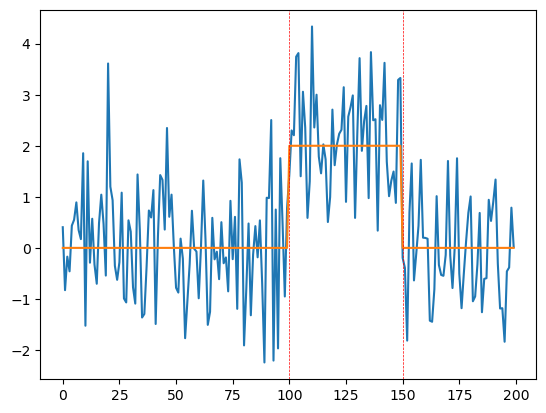

In [149]:
## Generating data with change in mean

sigma_noise = 1

a = np.ones((100,)) * 0
b = np.ones((50,)) * 2
c = np.ones((50,)) * 0

means = np.concatenate([a,b,c], axis = 0)
signal_means = np.concatenate([a,b,c], axis = 0) + sigma_noise * np.random.randn(200,)

plt.plot(signal_means)
plt.plot(means)
plt.axvline(x = 100, linestyle = "dashed", c = 'r', linewidth = 0.5)
plt.axvline(x = 150, linestyle = "dashed", c = 'r', linewidth = 0.5)



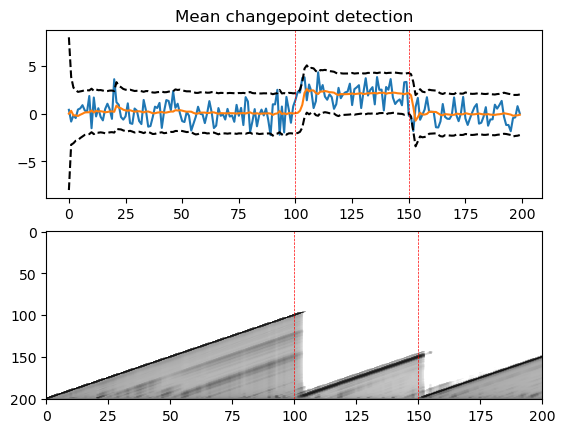

In [150]:
## Change in means

results = BOCD_mean(signal_means, 0, 3, sigma_noise, hazard_prob = 1/100)

fig, ax = plt.subplots(nrows = 2, ncols = 1)

ax[0].plot(signal_means)
ax[0].plot(results["post_mean"])
ax[0].plot(results["post_mean"] + 2*results["post_var"], linestyle = "dashed", c = 'k')
ax[0].plot(results["post_mean"] - 2*results["post_var"], linestyle = "dashed", c = 'k')
ax[0].axvline(x = 100, linestyle = "dashed", c = 'r', linewidth = 0.5)
ax[0].axvline(x = 150, linestyle = "dashed", c = 'r', linewidth = 0.5)
ax[0].set_title('Mean changepoint detection')

ax[1].imshow(np.rot90(results['post_R']), aspect='auto', cmap='gray_r', 
               norm=LogNorm(vmin=0.0001, vmax=1))
ax[1].axvline(x = 100, linestyle = "dashed", c = 'r', linewidth = 0.5)
ax[1].axvline(x = 150, linestyle = "dashed", c = 'r', linewidth = 0.5)
ax[1].set_xlim([0, len(signal_means)])
ax[1].margins(0)

### Change in variance

Model : piecewise IID Gaussian realisations with known mean $\mu$ but unknown precision $\lambda = \frac{1}{\sigma^2}$

In [45]:
def BOCD_var(signal, alpha0, beta0, hazard_prob, mu = 0):

    # Initialisation
    T = len(signal)
    log_R = -np.inf * np.ones((T+1, T+1)) # Run length posterior log-probability matrix
    log_R[0, 0] = 0 # At time 0, the posterior proability is initialised to 1 at R = 0

    posterior_precision = np.nan * np.empty(T) # Mean of the posterior distribution of the precision


    log_message = np.array([0]) # message initialised at 1
    log_H = np.log(hazard_prob) # Constant prior on changepoint probability.
    log_1_minus_H = np.log(1-hazard_prob)

    # Prior's parameters for the previous data point
    prior_shape = np.array([alpha0])
    prior_rate = np.array([beta0]) 


    # Online posterior distribution of the run length update:
    for t in range(1, T+1):
        x = signal[t-1] # Reading the new data point

        # Posterior mean for the precision
        posterior_precision[t-1] = prior_shape[t-1]/prior_rate[t-1]

        # Posterior predictive probabilities for each run length
        log_pis = student.logpdf(x, df = 2*prior_shape[:t], loc = mu, scale = prior_rate[:t]/prior_shape[:t])
        
        # Growth probability
        log_growth_probs = log_pis + log_message + log_1_minus_H

        # Changepoint probability
        log_cp_prob = logsumexp(log_pis + log_message + log_H)

        # Computing the evidence
        new_log_joint  = np.append(log_cp_prob, log_growth_probs)

        # Updating the run length distribution at time t
        log_R[t, :t+1]  = new_log_joint
        log_R[t, :t+1] -= logsumexp(new_log_joint)

        # Updating the prior parameters for the next step

        prior_shape = np.append([alpha0], prior_shape + 0.5)
        prior_rate = np.append([beta0], prior_rate + 0.5 * (x - mu)**2)
        
        # Pass message
        log_message = new_log_joint

    return {"post_R": np.exp(log_R), "post_precision": posterior_precision}

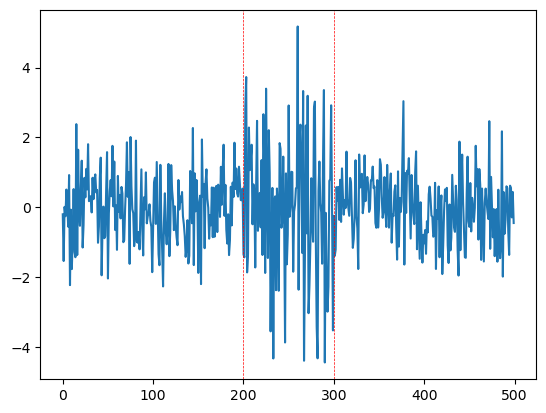

In [159]:
## Generating data with change in variance

sigma_noise = 1
mu = 0

a = 1*sigma_noise * np.random.randn(200,) + mu
b = 2*sigma_noise * np.random.randn(100,) + mu
c = 1*sigma_noise * np.random.randn(200,) + mu

signal_var = np.concatenate([a, b, c], axis = 0)

plt.plot(signal_var)

plt.axvline(x = 200, linestyle = "dashed", c = 'r', linewidth = 0.5)
plt.axvline(x = 300, linestyle = "dashed", c = 'r', linewidth = 0.5)

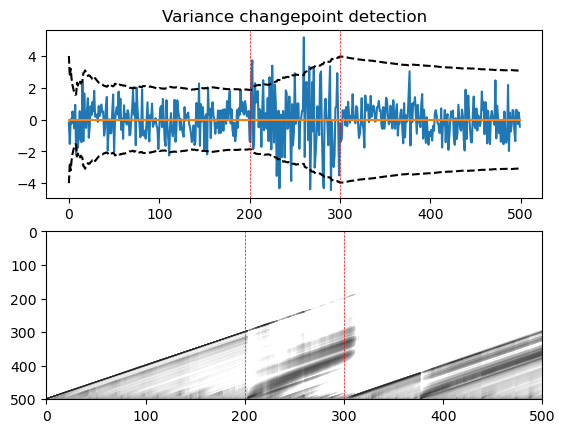

In [160]:
## Change in variance
signal = signal_var
T = len(signal)
results = BOCD_var(signal, 1, 2, hazard_prob = 1/200, mu = mu)

fig, ax = plt.subplots(nrows = 2, ncols = 1)

ax[0].plot(signal)
ax[0].plot(mu * np.ones((T,)))
ax[0].plot(mu * np.ones((T,)) + 2/results["post_precision"], linestyle = "dashed", c = 'k')
ax[0].plot(mu * np.ones((T,)) - 2/results["post_precision"], linestyle = "dashed", c = 'k')
ax[0].axvline(x = 200, linestyle = "dashed", c = 'r', linewidth = 0.5)
ax[0].axvline(x = 300, linestyle = "dashed", c = 'r', linewidth = 0.5)
ax[0].set_title("Variance changepoint detection")

ax[1].imshow(np.rot90(results['post_R']), aspect='auto', cmap='gray_r', 
               norm=LogNorm(vmin=0.0001, vmax=1))
ax[1].axvline(x = 200, linestyle = "dashed", c = 'r', linewidth = 0.5)
ax[1].axvline(x = 300, linestyle = "dashed", c = 'r', linewidth = 0.5)
ax[1].set_xlim([0, len(signal)])
ax[1].margins(0)